## Business Understanding

Choose stakeholder and figure out what they care about

- need two important parameter estimates as recommendations


## Exploratory Data Analysis

How/why does this data allow you to answer your questions?

**Data Visualization**
- Need 3 High Quality Data Visualizations

## Data Prep/Feature Eng

**Train/Test/Split**

**General Data Preparation**
- Nulls/dupes/outliers
- scaling
- transformations (for linearity)

**Feature Engineering**
- Encoding Variables (categories)
- Polynomial Features
- Interaction Terms
- NEED ONE NON-NUMERIC FEATURE

## Iterative Modeling

First try simplest approach.

Consider what the model baseline is

Start Adding Complexity and compare along the way
(**DOCUMENT THE ITERATIVE PROCESS**)

Models need to adhere to the assumptions of linear regression. If models do not adhere need to at least show that assumptions were tested for:

**ASSUMPTIONS**
- linear relationship between x and y - Heatmaps, scatter matrix
- low multicollinearituy - heatmaps, scatter matrix, VIF
- normal distribution of errors - kde, histogram, QQ-Plot, quantitative check (Jarque-Bera)
- homoskedasticity between errors - scatter plot between true and expected value

## Model Interpretation

Check for statistical Significance - check p-values of input variables

Are coefficients interpretable

Check R2, RMSE, MAE, MSE and other regression metrics

-----------------------


## STAKEHOLDER SELECTION

Stakeholder is Redfin

- Develop model to determine optimal purchasing price of homes and what renovations to make that will lead to greatest ROI


## BUSINESS UNDERSTANDING

**70% Rule:**

$$ 
MBP = (0.7ARV) - ERC
$$

where:

MBP = Maximum Buying Price

ARV = After-repair value

ERC = Estimated repair costs

in a sellers market we can adjust 70% to as high as 85%

## DATA EXPLORATION

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot

## Feature Selection

In [65]:
num_features_to_select = 93

# Use RSE or use manual formula string
use_RSE = False
formula_string = 'sqft_living+grade+suburb+rural'

In [66]:
df = pd.read_csv('data/cleaned_data.csv')
df.drop(['id','date','Unnamed: 0','lat'],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)

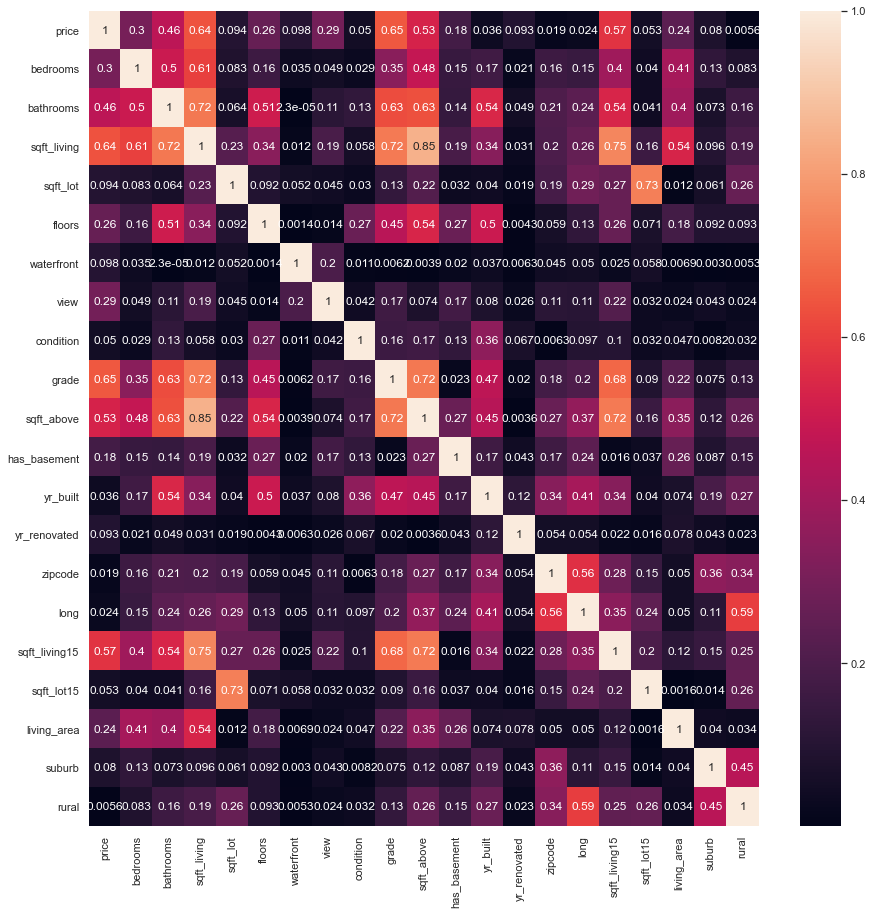

In [67]:
sns.set(rc={'figure.figsize':(15, 15)})

# Use the .heatmap method to depict the relationships visually!
sns.heatmap(df.corr().abs(),annot=True);

In [68]:
# Shows base dataset corrs
df_base = pd.read_csv('data/kc_house_data.csv')
df_base.drop(['id','date','yr_renovated'],axis=1,inplace=True)
df_base_corrs = df_base.corr()['price'].map(abs).sort_values(ascending=False)
df_base_corrs[:5]

price            1.000000
sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
Name: price, dtype: float64

In [69]:
# Shows cleaned dataset corrs
df_corrs = df.corr()['price'].map(abs).sort_values(ascending=False)
df_corrs[:5]

price            1.000000
grade            0.649461
sqft_living      0.639017
sqft_living15    0.572739
sqft_above       0.530734
Name: price, dtype: float64

In [70]:
# Create Train and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.2, random_state=42)

In [71]:
# Fit Scalar to Train
ss = StandardScaler()
ss.fit(X_train)

# Transform both Train and Test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [72]:
# Recursive Feature Selection
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=num_features_to_select)
select.fit(X=X_train_scaled, y=y_train)


keep_list = [(k,v) for k,v in zip(df.drop('price', axis=1).columns,select.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
if use_RSE == False:
    keep_list = formula_string.split('+')
keep_string = keep_string[:-1]

In [73]:
# Creates scaled features dataframe and then adds on price column

# Train
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = df.drop('price', axis=1).columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_final = pd.concat((X_train_scaled,y_train),axis=1)

# Test
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = df.drop('price', axis=1).columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)

----------------

## Model Results

In [74]:
# Baseline Model

baseline_mean = X_train_scaled_final['price'].mean()
model_base = DummyRegressor(strategy='mean', constant=baseline_mean)
baseline_mean

499116.46736483194

In [75]:
# OLS Regression on Train Data

if use_RSE == False:
    keep_string = formula_string

formula = f'price ~ {keep_string}'
model = ols(formula,X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     5080.
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:59:18   Log-Likelihood:            -2.2095e+05
No. Observations:               16424   AIC:                         4.419e+05
Df Residuals:                   16419   BIC:                         4.419e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.991e+05   1313.762    379.914      0.000    4.97e+05    5.02e+05
sqft_living   1.07e+05   1941.943     55.103      0.000    1.03e+05    1.11e+05
grade        1.007e+05   1904.133     52.895      0.000     9.7e+04    1.04e+05
suburb      -6.491e+04   1506.639    -43.085      0.000   -6.79e+04    -6.2e+04
rural       -6.128e+04   1528.385    -40.093      0.000   -6.43e+04   -5.83e+04
==============================================================================
Omnibus:                     3430.624   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9866.926
Skew:                           1.098   Prob(JB):                         0.00
Kurtosis:                       6.097   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# OLS Regression on Test Data

model_test = ols(formula,X_test_scaled_final).fit()
model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     1144.
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:59:18   Log-Likelihood:                -55199.
No. Observations:                4106   AIC:                         1.104e+05
Df Residuals:                    4101   BIC:                         1.104e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.956e+05   2605.829    190.199      0.000    4.91e+05    5.01e+05
sqft_living   1.05e+05   3858.400     27.215      0.000    9.74e+04    1.13e+05
grade        9.412e+04   3806.364     24.727      0.000    8.67e+04    1.02e+05
suburb      -6.788e+04   2982.463    -22.760      0.000   -7.37e+04    -6.2e+04
rural       -6.361e+04   3036.652    -20.948      0.000   -6.96e+04   -5.77e+04
==============================================================================
Omnibus:                      859.070   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2659.193
Skew:                           1.065   Prob(JB):                         0.00
Kurtosis:                       6.318   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-------------

## MODEL VALIDATION

### Check Normal Distribution of Input Variables

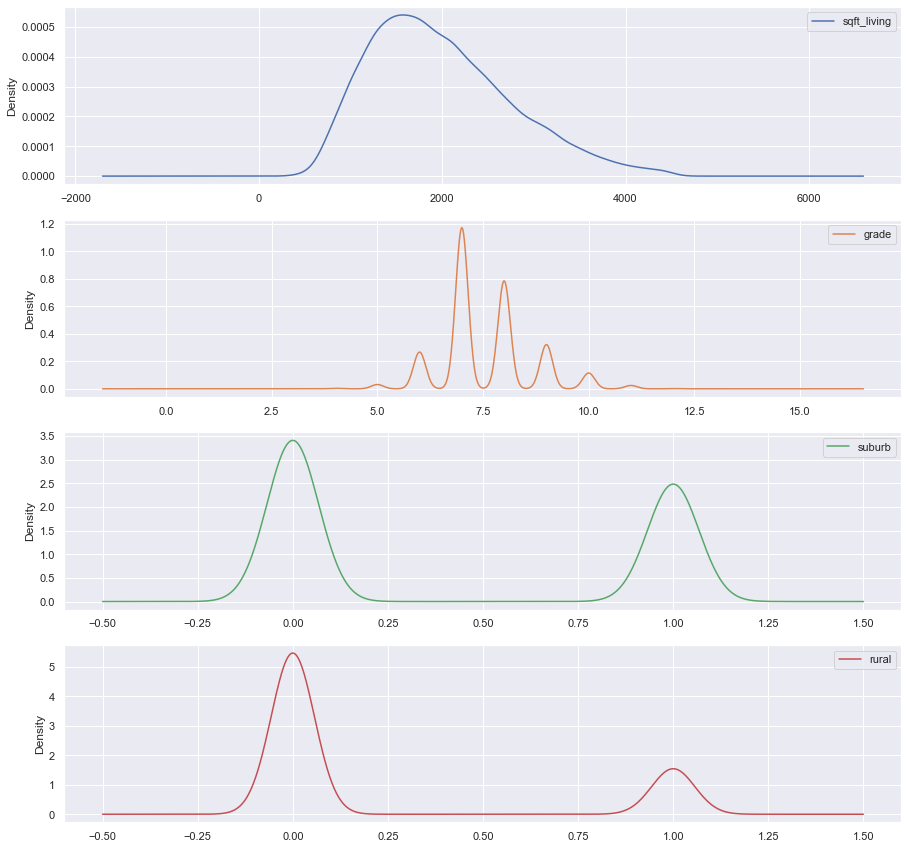

In [77]:
if use_RSE:
    df.filter([x[0] for x in keep_list if x[1] == True],axis=1).plot.kde(subplots=True,sharex=False)
else:
    df.filter(keep_list,axis=1).plot.kde(subplots=True,sharex=False)
plt.show()

### Checking Normal Distribution of Residuals

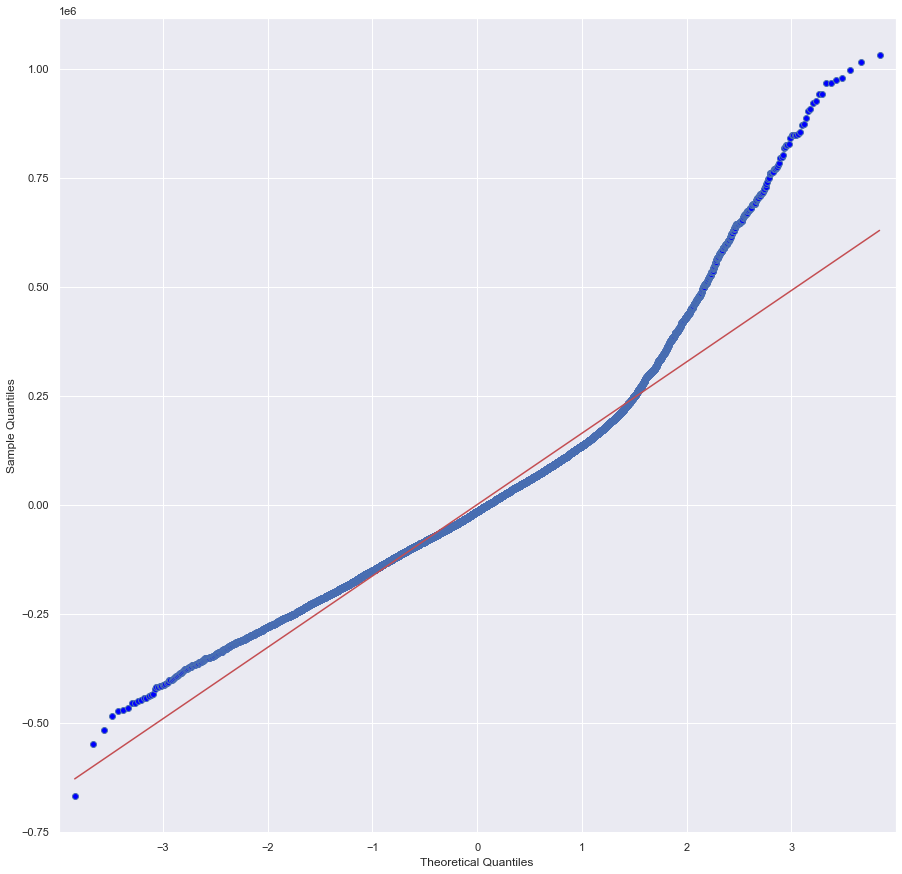

In [78]:
y_hat_train = model.predict(X_train_scaled)
y_hat_test = model_test.predict(X_test_scaled)

qqplot(y_train-y_hat_train,line='r')
plt.show()

### Checking for Heteroskedasticity and Lack of Trend in Errors

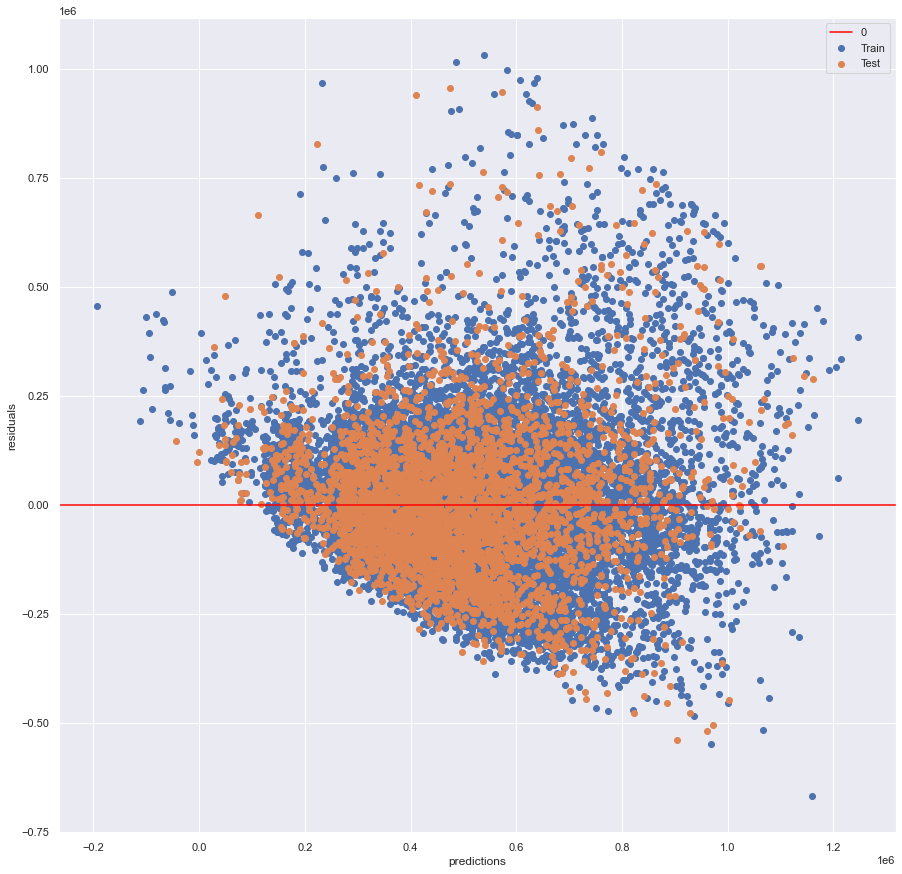

In [79]:
plt.scatter(y_hat_train, y_train - y_hat_train, label='Train')
plt.scatter(y_hat_test, y_test - y_hat_test, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

### Checking Root Mean Squared Error

In [80]:
print('TRAIN RMSE:',rmse(y_train,y_hat_train))
print('TEST RMSE:',rmse(y_test,y_hat_test))
print('RMSE DIFF:', abs(rmse(y_train,y_hat_train)-rmse(y_test,y_hat_test)))

TRAIN RMSE: 168341.06418654727
TEST RMSE: 166809.0694866682
RMSE DIFF: 1531.9946998790838


### Checking Linearity and Multicollinearity

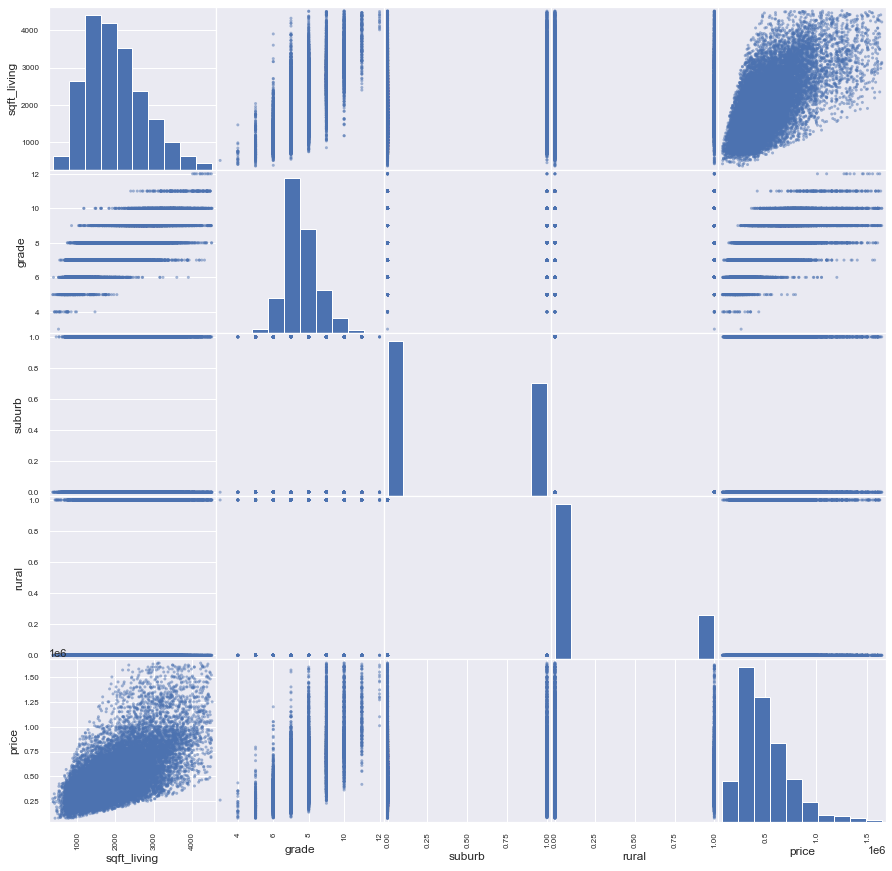

In [81]:
if use_RSE:
    scatter_keep_list = keep_list.copy()
    scatter_keep_list.append(('price',True))
    pd.plotting.scatter_matrix(df.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1))
    plt.show()

else:
    scatter_keep_list = keep_list.copy()
    scatter_keep_list.append('price')
    pd.plotting.scatter_matrix(df.filter(scatter_keep_list,axis=1))
    plt.show()

In [82]:
if use_RSE:
    corr_print = X_train_scaled_final.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1).corr().abs()['price'].sort_values(ascending=False)
else:
    corr_print = X_train_scaled_final.filter(scatter_keep_list,axis=1).corr().abs()['price'].sort_values(ascending=False)
corr_print

price          1.000000
grade          0.655304
sqft_living    0.643200
suburb         0.077459
rural          0.009535
Name: price, dtype: float64

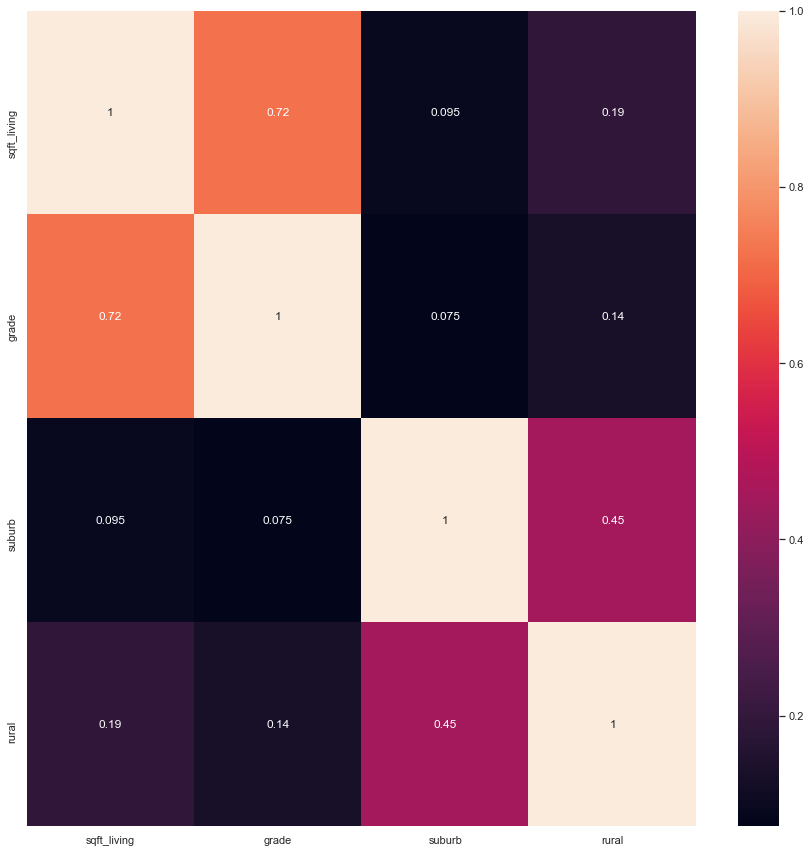

In [83]:
if use_RSE:
    sns.heatmap(X_train_scaled.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1).corr().abs(),annot=True)
else:
    sns.heatmap(X_train_scaled.filter(keep_list,axis=1).corr().abs(),annot=True)